---
### STEP 1. 데이터셋 구성하기

In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [5]:
train_img = train_x
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화

In [6]:
train_x.shape

(50000, 32, 32, 3)

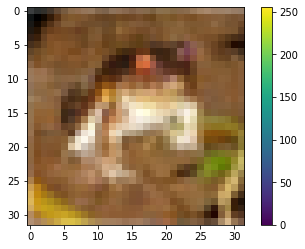

In [7]:
plt.imshow(train_img[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

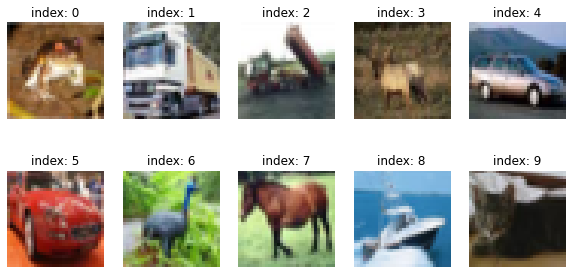

In [8]:
# 이미지 10개 체크
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_img[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

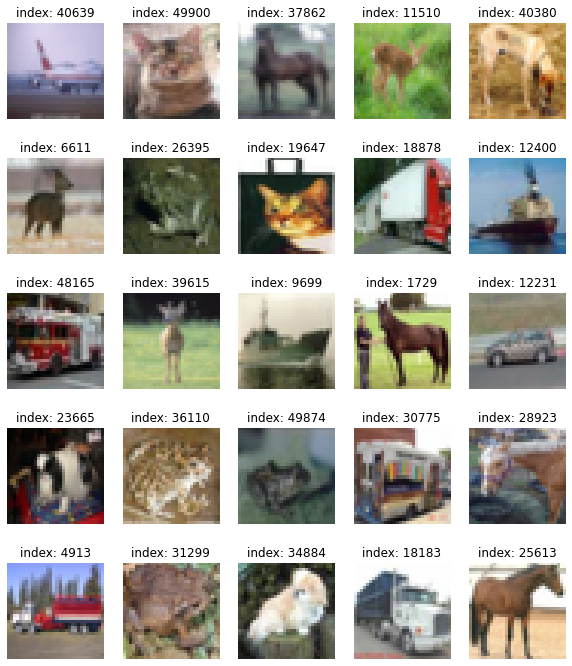

In [9]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_img[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

- 로드한 학습 데이터를 시각화를 통해 확인

In [10]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

---
### 2. 생성자 모델 구현

In [12]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()
    # First: Dense layer
    model.add(layers.Dense(4*4*256, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (3, 3), activation='tanh', padding='same'))
    return model

In [13]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0

In [14]:
# 랜덤 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [15]:
# 생성자 모델에 입력값으로 노이즈를 넣고 간단하게 결과 이미지 생성
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

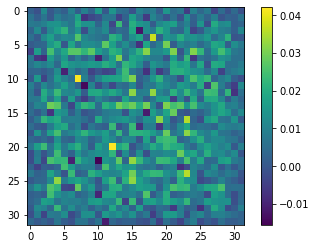

In [16]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

---
### 3. 판별자 모델 구현

In [17]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    # Sixth: Dense Layer
    model.add(layers.Dense(1))
    return model

In [18]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)        

In [19]:
# 위에서 생성한 가짜 이미지를 판별자에 입력
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00113579]], dtype=float32)>

---
### 4. 손실함수와 최적화 함수 구현

In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- fake_output가 1에 가까워지기를 원한다. 

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### 최적화 함수

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [25]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

---
### 5. 훈련과정 상세 기능 구현

In [26]:
# @tf.function 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환됩니다.
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [27]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [28]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

- loss와 accuracy 그래프

In [29]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---
### 6. 학습 과정 진행

In [30]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [31]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

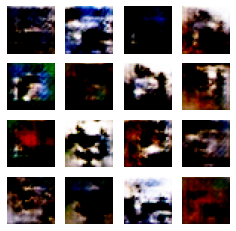

Time for training : 3689 sec


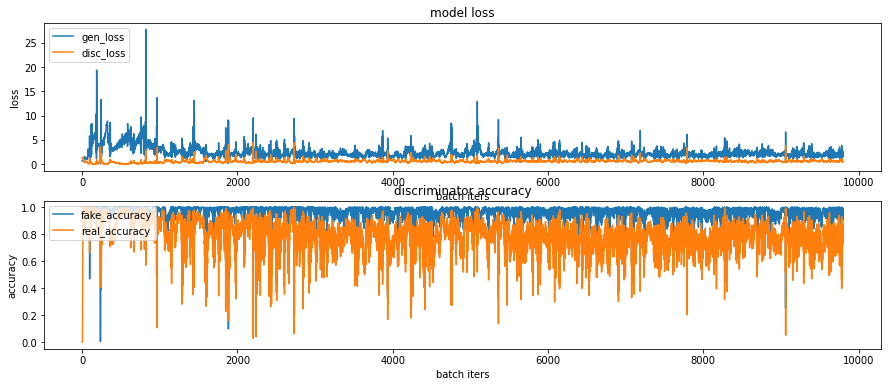

CPU times: user 1h 1min 4s, sys: 46.4 s, total: 1h 1min 50s
Wall time: 1h 1min 30s


In [32]:
%%time
train(train_dataset, EPOCHS, save_every)